In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import Audio

In [2]:
def get_interpolated(array, index):
    if not hasattr(array, "__len__"): return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [3]:
def calculate_next_psi(psi, dt, potential):
    n = psi.shape[0]
    
    # potential part
    next_psi = psi * np.exp(1j * dt * potential)

    next_psi = np.fft.fft2(next_psi)

    # time part
    indices = 2 * np.pi * np.min([np.arange(n), n-np.arange(n)], axis=0)
    k = indices.reshape(-1, 1)
    l = indices.reshape(1, -1)
    theta = (k*k + l*l) * dt
    next_psi *= np.exp(1j * theta)
    
    next_psi = np.fft.ifft2(next_psi)
    
    return next_psi

In [4]:
def gaussian(x, y, n, offset, width):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return np.exp(-(x*x + y*y) / (width*width)) + 0j

In [5]:
def parabolar(x, y, n, offset, factor):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return factor * (x*x + y*y) + 0j
    

In [6]:
def circle(rad, radius, offset, n):
    return (radius * np.array([np.cos(rad), np.sin(rad)]) + offset) * n//2 + n//2

In [7]:
np.concatenate(([5], circle(0, 1, 0, 128)), axis=0)

array([  5., 128.,  64.])

In [8]:
n = 128

samplerate = 44100
frequency = 110
interest_radius = 0.6
interest_center = [0, 0]

psi_init = np.array([[gaussian(x, y, n, offset=[-0.6, 0.0], width=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[parabolar(x, y, n, offset=[0,0], factor=10000) for x in range(n)] for y in range(n)])

# barrier
double_slit = [(-5, -3), (3, 5)]
single_slit = [(-2, 2)]
slits = double_slit

barrier_height = 1e20
barrier = [barrier_height] * n
for s in slits:
    barrier[n//2+s[0]:n//2+s[1]] = [0] * (s[1]-s[0])
for i in range(n):
    potential[:, n//2-1] += barrier

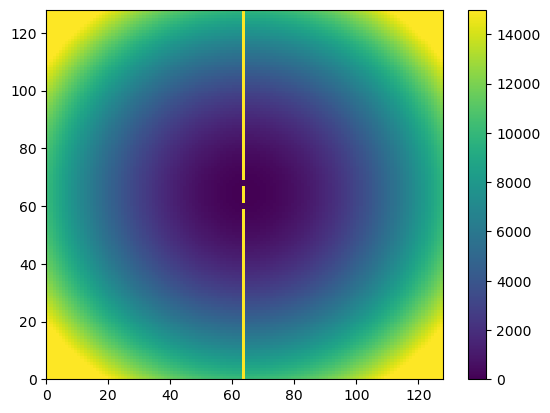

In [9]:
#plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
plt.pcolormesh(np.abs(potential), vmax=15000)
plt.colorbar()
plt.show()

In [10]:
frame_amount = 500

psi = psi_init
frames = [psi]

for i in range(frame_amount-1):
    for timestep in range(20):
        psi = calculate_next_psi(psi, 0.00001, potential)
    print("\r" + str(i) + " " if i % 10 == 0 else "", end="")
    frames.append(psi)

print("\nFinished simulation")

490 
Finished simulation


In [11]:
# create visual barrier for plot
def visual_barrier(barrier_gaps):
    w = 2
    start = 0
    rects = []
    for g in barrier_gaps:
        end = n//2 + g[0]
        rect = patches.Rectangle(((n-w)//2, start), 2, end - start, linewidth=0, facecolor='#5555fa')
        start = n//2 + g[1]
        rects.append(rect)
    rects.append(patches.Rectangle(((n-w)//2, start), 2, n - start, linewidth=0, facecolor='#5555fa'))
    return rects

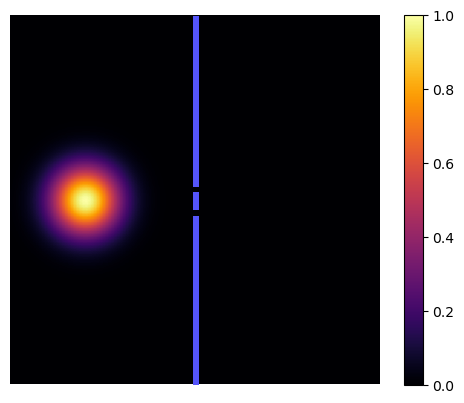

In [17]:
# FuncAnimation
fps = 20

fig, ax = plt.subplots()
plt.axis('off')  # big performance boost

cax = ax.imshow(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
for b in visual_barrier(slits):
    ax.add_patch(b)
fig.colorbar(cax)  # no performance impact (?)

def animate(i):
    cax.set_array(pow(np.abs(frames[i]), 2.0/3.0))

anim = animation.FuncAnimation(fig, animate, frames=len(frames))
anim.save('output/visual.mp4', fps=fps, dpi=150, bitrate=4000)

In [35]:
# Sonification
rad_per_sample = 2 * np.pi * frequency / samplerate
audio = [np.square(np.abs(get_interpolated(frames, np.concatenate((np.array([i * fps/samplerate]), circle(rad_per_sample * i, interest_radius, interest_center, n)), axis=0)))) for i in range(samplerate*frame_amount//fps)]

print("Finished sonicifaction")

Finished sonicifaction


In [36]:
Audio(audio, rate=samplerate)

In [37]:
import pickle

In [38]:
f = open("output/audio_save_double_1000_10_0.00002.pckl", "wb")
pickle.dump(audio, f)
f.close()

In [24]:
f = open('output/frames_save_double_1000_10_0.00002.pckl', 'rb')
obj = pickle.load(f)
f.close()